In [38]:
import numpy as np
from matplotlib import pyplot as plt

In [39]:

class particle():
    def __init__(self, mass, x0, v0):
        self.mass = mass
        self.x0 = x0
        self.v0 = v0

        self.x = x0
        self.v = v0

    def energy(self, v):
        return 0.5 * self.mass * np.linalg.norm(v) ** 2

    def momentum(self):
        return self.mass * self.velocity

class spring():
    def __init__(self, k, x0, v0):
        self.k = k
        self.x0 = x0
        self.v0 = v0

    def energy(self, x):
        return 0.5 * self.k * np.linalg.norm(x - self.x0) ** 2


In [40]:

def euler_integration(particle, force, t_max, dt = 0.001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []

    for t in t_array:
        particle.x = particle.x + particle.v * dt
        particle.v = particle.v + force(particle) / particle.mass * dt

        pos.append(particle.x)
        vel.append(particle.v)
        
    return np.array(pos), np.array(vel)

In [64]:
def verlet_integrate(particle, force, t_max, dt = 0.001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []
    for i in range(len(t_array)):

        pos.append(particle.x)
        vel.append(particle.v)

        a = force(particle) / particle.mass

        if i == 0:
            x_prev = particle.x - particle.v * dt + 0.5 * a * dt ** 2   # this is awful
        else:
            x_prev = pos[i-1]

        
        x_current = particle.x
        particle.x = 2 * particle.x - x_prev + dt * dt * a
        particle.v = (particle.x - x_current) / dt

    return np.array(pos), np.array(vel)


In [42]:
def actual_verlet_integrate(particle, force, t_max, dt = 0.001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []
    for t in t_array:
        pos.append(particle.x)
        vel.append(particle.v)
        a = force(particle) / particle.mass
        particle.x = particle.x + particle.v * dt + 0.5 * a * dt ** 2
        particle.v = particle.v + a * dt
    return np.array(pos), np.array(vel)

In [43]:
def runge_kutta(particle, force, t_max, dt = 0.00001):
    t_array = np.arange(0, t_max, dt)
    pos = []
    vel = []
    for t in t_array:
        a = force(particle) / particle.mass
        k1 = particle.v
        l1 = a
        k2 = particle.v + l1 * dt / 2
        l2 = a
        k3 = particle.v + l2 * dt / 2
        l3 = a
        k4 = particle.v + l3 * dt
        l4 = a
        particle.x = particle.x + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6
        particle.v = particle.v + (l1 + 2 * l2 + 2 * l3 + l4) * dt / 6
        
        pos.append(particle.x)
        vel.append(particle.v)
    
    return np.array(pos), np.array(vel)

In [44]:
# spring case

class spring_mass_system():
    def __init__(self, mass, k, x_m = np.zeros(3, dtype = float), v0 = np.zeros(3, dtype = float), x_s = np.zeros(3, dtype = float)):
        self.k = k
        self.mass = mass

        self.spring = spring(k, x_s, v0)
        self.particle = particle(mass, x_m, v0)

    def energy(self):
        return self.spring.energy(self.particle.x) + self.particle.energy(self.particle.v)
    
    def force(self, particle):
        #return np.gradient(self.energy(particle.x), particle.x)
        return - self.k * (particle.x - self.spring.x0)
    
    def solve(self, method, t_max, dt = 0.001):
        pos,vel = method(self.particle, self.force, t_max, dt)
        return pos, vel
    
    def solution(self, t):
        x0 = self.particle.x0[0]
        v0 = self.particle.v0[0]
        w = np.sqrt(self.k / self.mass)
        A = x0
        B = v0 / w
        return A * np.cos(w * t) + B * np.sin(w * t)


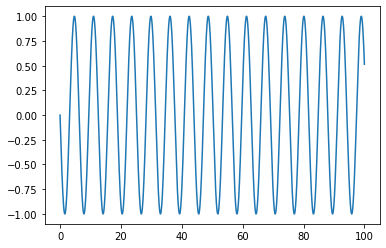

In [45]:
mass_position = np.array([0, 0, 0], dtype = float)
velocity = np.array([1, 0, 0], dtype = float)
system = spring_mass_system(1, 1, mass_position, velocity)

T = 100
dt = 0.01

pos,vel = system.solve(verlet_integrate, T, dt)
t_array = np.arange(0, T, dt)
plt.plot(t_array, pos[:, 0])
#plt.plot(t_array, system.solution(t_array))

final rms error for verlet_integrate is 1.4211119952705396
final rms error for euler_integration is 0.04485855398714776
final rms error for actual_verlet_integrate is 1.2006788098452719


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


final rms error for runge_kutta is 1.2015049978296484


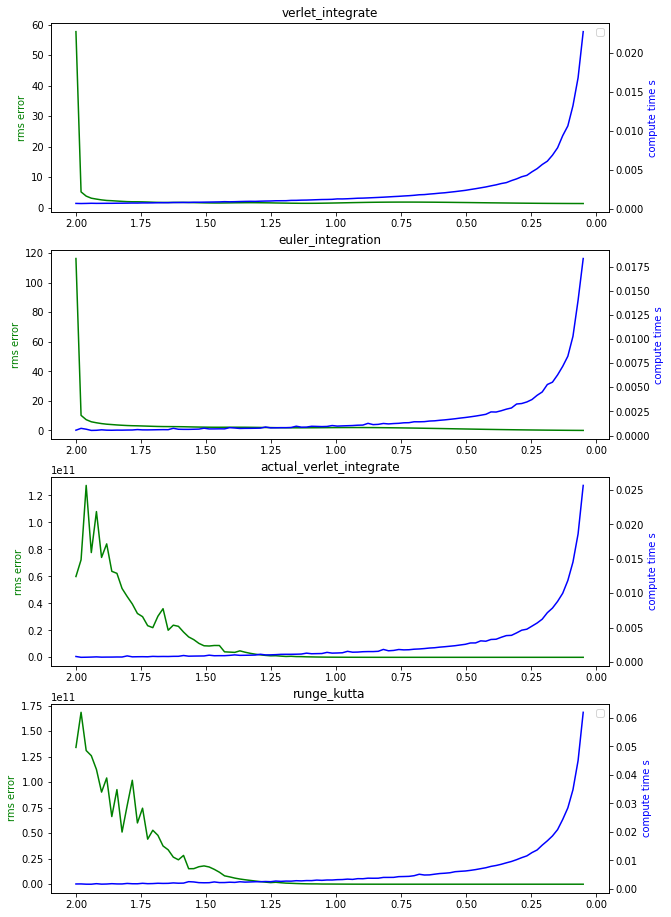

In [46]:
errors = []
solve_times = []

def test_iteration(method, dt):
  
  T = 100
  mass_position = np.array([1, 0, 0], dtype = float)
  velocity = np.array([1, 0, 0], dtype = float)
  system = spring_mass_system(1, 1, mass_position, velocity)

  pos, vel = system.solve(method, T, dt)
  t_array = np.arange(0, T, dt)
  rms_error = np.sqrt(np.mean((pos[:, 0] - system.solution(t_array)) ** 2, axis = 0))
  errors.append( rms_error )

def test_method(plot_axis, method):
  solve_times = []
  errors = []
  time_steps = np.linspace(2,0.05,100)
  for dt in time_steps:
    t = %timeit -q -n1 -r1 -o test_iteration(method,dt)
    solve_times.append(t.best)

  plot_axis.plot(time_steps, errors, 'g')
  plot_axis.set_ylabel('rms error', color='g')
  time_axis = plot_axis.twinx()
  time_axis.plot(time_steps, solve_times, 'b')
  time_axis.set_ylabel('compute time s', color='b')
  plot_axis.set_title(method.__name__)
  plot_axis.set_xlim(plot_axis.get_xlim()[::-1])

  print(f"final rms error for {method.__name__} is {errors[-1]}")

methods = [verlet_integrate, euler_integration, actual_verlet_integrate, runge_kutta]
fig, axs = plt.subplots(len(methods), 1, figsize = (10, 4*len(methods)))

for m in methods:
  test_method(axs[methods.index(m)], m)

axs[0].legend()

plt.legend()
plt.show()

runge kutta method may seem worse, however its second, third and fourth derivatives are far more accurate than any of the other methods

Dont know what the definiton of unstable is but is around when dt = 1.95 to 2.0

energy change is 11.276229959464892 at dt = 1.9192982456140353
energy change is 12.029018818212538 at dt = 1.9203007518796993
energy change is 11.923890684355758 at dt = 1.9213032581453635
energy change is 10.949176943357216 at dt = 1.9223057644110277
energy change is 10.807799887643947 at dt = 1.9313283208020051
energy change is 13.036149771744519 at dt = 1.9323308270676693
energy change is 14.367758891194025 at dt = 1.9333333333333333
energy change is 14.553290343075837 at dt = 1.9343358395989976
energy change is 13.518936719517404 at dt = 1.9353383458646618
energy change is 11.394013314582924 at dt = 1.9363408521303258
energy change is 10.559506975742462 at dt = 1.9453634085213034
energy change is 14.497422766705702 at dt = 1.9463659147869676
energy change is 17.483925107112398 at dt = 1.9473684210526316
energy change is 18.86818659216232 at dt = 1.9483709273182959
energy change is 18.284596936174033 at dt = 1.94937343358396
energy change is 15.763414592747324 at dt = 1.950375939849

Text(0, 0.5, 'energy error')

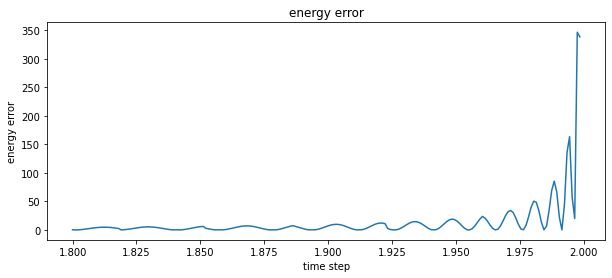

In [73]:


T = 100
time_steps = np.linspace(1.8,2.2,400)

energy_errors = []

for dt in time_steps:
    mass_position = np.array([0, 0, 0], dtype = float)
    velocity = np.array([1, 0, 0], dtype = float)
    system = spring_mass_system(1, 1, mass_position, velocity)
    initial_energy = system.energy()
    pos,vel = system.solve(verlet_integrate, T, dt)
    final_energy = system.energy()
    energy_change = np.abs(final_energy - initial_energy)
    if energy_change > 10:
        print(f"energy change is {energy_change} at dt = {dt}")
        if energy_change > 1000:
            break
        
    energy_errors.append(energy_change)

print(f"unstable energy change is {final_energy - initial_energy} at dt = {dt}")

fig, ax = plt.subplots(1, 1, figsize = (10, 4))

ax.plot(time_steps[:len(energy_errors)], energy_errors)
ax.set_title('energy error')
ax.set_xlabel('time step')
ax.set_ylabel('energy error')
#plt.plot(t_array, system.solution(t_array))

Now define an orbital mechanics system

In [71]:
G = 6.67408e-11

class orbital_system():
    def __init__(self, M, m, planet_pos, planet_vel): # relative to sun
        self.M = M
        self.m = m

        self.sun = particle(M, np.zeros(3), np.zeros(3)) # coordinate system based on star
        self.planet = particle(m, planet_pos, planet_vel)
    
    def force(self, particle): # force on planet
        return -G * self.M * self.m * particle.x / np.linalg.norm(particle.x) ** 3

    def solve(self, method, t_max, dt = 0.001):
        pos,vel = method(self.planet, self.force, t_max, dt)
        return pos, vel


Scenario 1
Mars descent

Text(0, 0.5, 'altitude (m)')

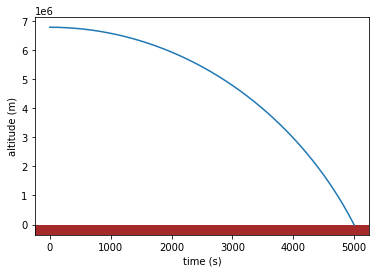

In [70]:
from matplotlib.patches import Rectangle

mars_mass = 6.42e23
mars_radius = 3.3895e6
meteor_mass = 1e3

initial_altitude = 3 * mars_radius

meteor_position = np.array([initial_altitude, 0, 0], dtype = float)
meteor_velocity = np.array([0, 0, 0], dtype = float)

meteor_planet_collision = orbital_system(mars_mass, meteor_mass, meteor_position, meteor_velocity)

T = 5000
dt = 0.01
t_array = np.arange(0, T, dt)
pos, vel = meteor_planet_collision.solve(verlet_integrate, T, dt)

altidudes = np.linalg.norm(pos, axis = 1) - mars_radius

ax = plt.gca()
ax.plot(t_array, altidudes)
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.add_patch(Rectangle((x0 - .5, y0 - .5), x1 - x0, - y0, facecolor="brown"))
plt.xlabel('time (s)')
plt.ylabel('altitude (m)')

Scenario 2

Phobos orbiting mars in a circular orbit. Phobos is actually in an orbit of eccentricity 0.0151 which still looks like a circle

(-10315800.330106026,
 10315800.02844849,
 -10315800.168303395,
 10315800.179885555)

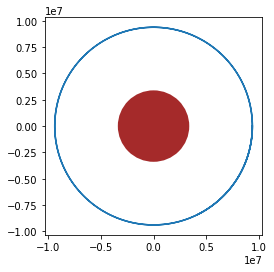

In [ ]:
from matplotlib.patches import Circle

mars_mass = 6.42e23
mars_radius = 3.3895e6
phobos_mass = 1.0659e16
phobos_orbit_radius = 9.378e6

def velocity_for_circular_orbit(m1, m2, r):
    return np.sqrt(G * (m1 + m2) / r)

phobos_position = np.array([phobos_orbit_radius, 0, 0], dtype = float)
phobos_velocity = np.array([0, velocity_for_circular_orbit(mars_mass, phobos_mass, phobos_orbit_radius), 0])
mars_moons_orbit = orbital_system(mars_mass, phobos_mass, phobos_position, phobos_velocity)

pos,vel = mars_moons_orbit.solve(verlet_integrate, 60000, 0.1)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), mars_radius, facecolor="brown"))
ax.axis('scaled')

Scenario 3

Elliptic orbit of Bennu, an asteroid thats also a potentially hazardous object which has a high chance of impacting earth between the years 2178 - 2290.
Bennu has an orbit of eccentricity of 0.20375
The sun is also scaled up by 100x to be seen clearly

(-1163935974428.1074,
 195987713427.95636,
 -422999614871.393,
 422999580088.47833)

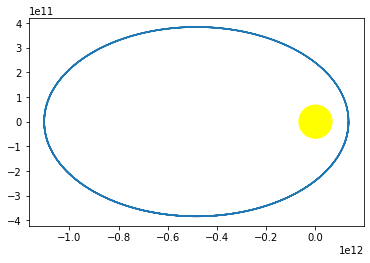

In [ ]:
sun_mass = 1.989e30
sun_radius = 6.957e8
bennu_mass = 7.329e10

bennu_position = np.array([134.173e9, 0, 0])
bennu_velocity = np.array([0, 1.5*28e3, 0])

mars_moons_orbit = orbital_system(sun_mass, bennu_mass, bennu_position, bennu_velocity)

pos,vel = mars_moons_orbit.solve(verlet_integrate, 1000000000, 1000)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), sun_radius * 10 ** 2, facecolor="yellow"))
ax.axis('scaled')

Scenario 4 Voyager 1 jupyter gravity jump

(-1123616797.310515, 525322743.5208129, -502030485.8439025, 1314388202.7219532)

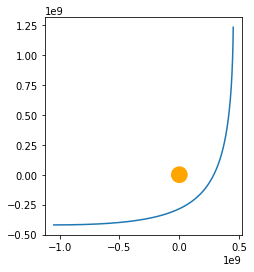

In [69]:

jupyter_mass = 1.898e27
jupyter_radius = 6.9911e7
voyager1_mass = 825.5
voyager1_position = np.array([- 15 * jupyter_radius, - 6 * jupyter_radius, 0])
voyager1_velocity = np.array([2e4, 0, 0])

voyager1_gravity_jump = orbital_system(jupyter_mass, voyager1_mass, voyager1_position, voyager1_velocity)

pos,vel = voyager1_gravity_jump.solve(verlet_integrate, 110000, 1)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), jupyter_radius, facecolor="orange"))
ax.axis('scaled')

Scenario 4 part 2 hyperbolic escape from planet surface
Future Clipper spacecraft taking off from Jupyters moon Europa

(-2200911.297954848,
 11899137.257051809,
 -1908317.8392172693,
 2076525.6440336222)

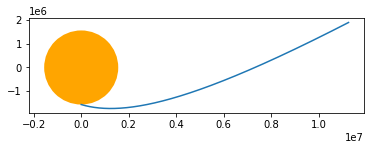

In [67]:

europa_mass = 4.799e22
europa_radius = 1.56e6
clipper_mass = 400
clipper_position = np.array([0, - europa_radius, 0])
clipper_velocity = np.array([2e3, -6e2, 0])

clipper_hyperbolic_escape = orbital_system(europa_mass, clipper_mass, clipper_position, clipper_velocity)

pos,vel = clipper_hyperbolic_escape.solve(verlet_integrate, 10000, 1)

ax = plt.gca()
y0,_ = ax.get_ylim()
x0,x1 = ax.get_xlim()
ax.plot(pos[:, 0], pos[:, 1])
ax.add_patch(Circle((0, 0), europa_radius, facecolor="orange"))
ax.axis('scaled')